# Classifying Events with:
* Logistic Regression
* Random Forests
* SVM
* Naive Bayes



In [3]:
#Use mne XDawn for preprocessing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

import mne
from mne import io, pick_types, read_events, Epochs
# from mne.datasets import sample
from mne.preprocessing import Xdawn
from mne.decoding import Vectorizer
from mne.viz import tight_layout

import os
import os.path as op

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
matplotlib.rcParams.update({'font.size': 15})

#data path for each run of each subject.
drive_data_path = 'E:\eeg_data'

#data path on my external hdd for folder containing all tests of each subject in one file
drive_all_data_path = 'E:\eeg_data\ica_140_500_0.1'

In [2]:
# import all runs data from 10 subjects

#initalize a np array of numbers from 1 to 5. This is the number of subjects
np.random.seed(41)
numb_subj = np.random.randint(1,25,5)
numb_subj
print("subject number used for classification:",numb_subj)
#empty array that will have all file names
files = []

for i in range(len(numb_subj)):
    files.append(str('subject' + str(numb_subj[i]) + '_all_runs-epo.fif'))

#convert to np array
files = np.array(files)

all_data = []
for i in range(len(files)):
     all_data.append(mne.read_epochs(op.join(drive_all_data_path, files[i]),
                          preload=True));

('subject number used for classification:', array([1]))
Reading E:\eeg_data\ica_140_500_0.1\subject1_all_runs-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [12]:
#extract event_id 4 and 5 from all data

all_epochs = []
for i in range(len(all_data)):
    all_epochs.append(all_data[i][(all_data[i].events[:,-1] == 4) | (all_data[i].events[:,-1] == 5)])

In [13]:
#concatenate epochs list
epochs = mne.concatenate_epochs(all_epochs)

2186 matching events found
Created an SSP operator (subspace dimension = 1)
0 bad epochs dropped


In [14]:
epochs = epochs.pick_channels(epochs.ch_names[:60])

In [15]:
clf = make_pipeline(Xdawn(n_components = 3),
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l1'))
#cross validator
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)


#Do cross-validation
labels = epochs.events[:,-1]
preds = np.empty(len(labels))

for train, test in cv.split(epochs, labels):
    clf.fit(epochs[train], labels[train])
    preds[test] = clf.predict(epochs[test])
    
target_names = ['new', 'scramble']
report = classification_report(labels, preds, target_names=target_names)
print(report)

             precision    recall  f1-score   support

        new       0.63      0.67      0.65      1195
   scramble       0.57      0.52      0.54       991

avg / total       0.60      0.60      0.60      2186



In [16]:
# Normalized confusion matrix
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

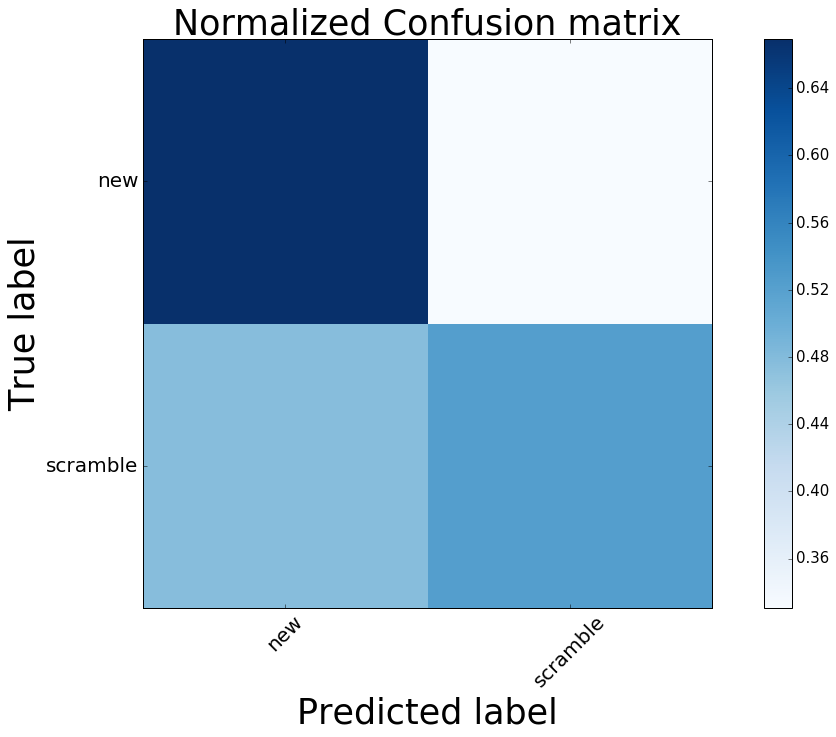

In [17]:
# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix', fontsize = 35)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, fontsize = 20)
plt.yticks(tick_marks, target_names, fontsize = 20)
tight_layout()
plt.ylabel('True label', fontsize = 35)
plt.xlabel('Predicted label',fontsize = 35)
plt.show()

In [18]:
clf.score(epochs[test],labels[test])

0.66972477064220182

## More tests by sampling more files

In [110]:
np.random.seed(42)
subjects = []
#generate 10 random samples of 5 files 
for i in range(10):
    subjects.append(np.random.choice(25,5))
subjects = np.array(subjects)
print(subjects)

[[ 6 19 14 10  7]
 [20  6 18 22 10]
 [10 23 20  3  7]
 [23  2 21 20  1]
 [23 11  5  1 20]
 [ 0 11 21 11 24]
 [16  9 15 14 14]
 [18 11 22 19 24]
 [ 2  4 18  6 20]
 [ 8  6 17  3 24]]


In [5]:
#read file
def read_file(path, file_name):
    return mne.read_epochs(op.join(path, file_name),
                          preload=True);

In [19]:
def filter_new_scrambled(epochs):
    """Filter events in epoch data
    epochs: mne.epochs.EpochsFIF object 
    """
    
    return epochs[(epochs.events[:,-1] == 4) | (epochs.events[:,-1] == 5)] 

In [15]:
epochs = read_file(drive_all_data_path,'subject1_all_runs-epo.fif');

Reading E:\eeg_data\ica_140_500_0.1\subject1_all_runs-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 61) active
    Found the data of interest:
        t =       0.00 ...    1400.00 ms
        0 CTF compensation matrices available
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1121 matching events found
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [20]:
epochs = filter_new_scrambled(epochs)

In [1]:
#create a funcation to minimize number of cells used

def classifer(sample_files):
    print(sample_files)
    files = []
    
    for i in range(len(sample_files)):
        files.append(str('subject' + str(sample_files[i]) + '_all_runs-epo.fif'))

    #convert to np array
    files = np.array(files)

    #load all data from drive
    all_data = []
    for i in range(len(files)):
         all_data.append(mne.read_epochs(op.join(drive_all_data_path, files[i]),
                          preload=True));
    
    #filter for events 4 and 5
    all_epochs = []
    for i in range(len(all_data)):
        all_epochs.append(all_data[i][(all_data[i].events[:,-1] == 4) | (all_data[i].events[:,-1] == 5)])
    
    #concatenate epochs list
    epochs = mne.concatenate_epochs(all_epochs)
    
    #remove 61st channel
    epochs = epochs.pick_channels(epochs.ch_names[:60])
    
    #generate pipeline
    clf = make_pipeline(Xdawn(n_components = 3),
                    Vectorizer(),
                    MinMaxScaler(),
                    LogisticRegression(penalty='l2'))
    
    #cross validator
    cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

    
    #Do cross-validation
    labels = epochs.events[:,-1]
    preds = np.empty(len(labels))
    
    #train!
    for train, test in cv.split(epochs, labels):
        clf.fit(epochs[train], labels[train])
        preds[test] = clf.predict(epochs[test])
    
    
    target_names = ['new', 'scramble']
    report = classification_report(labels, preds, target_names=target_names)
    
    # print(report)
    
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    
    score = clf.score(epochs[test],labels[test])
    
    return score, report, labels, preds, cm_normalized

In [75]:
target_names = ['new', 'scramble']
report = classification_report(labels, preds, target_names=target_names)
print(report)

             precision    recall  f1-score   support

        new       0.69      0.76      0.72      1106
   scramble       0.58      0.49      0.53       751

avg / total       0.64      0.65      0.64      1857



In [76]:
cm = confusion_matrix(labels, preds)
cm_normalized = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

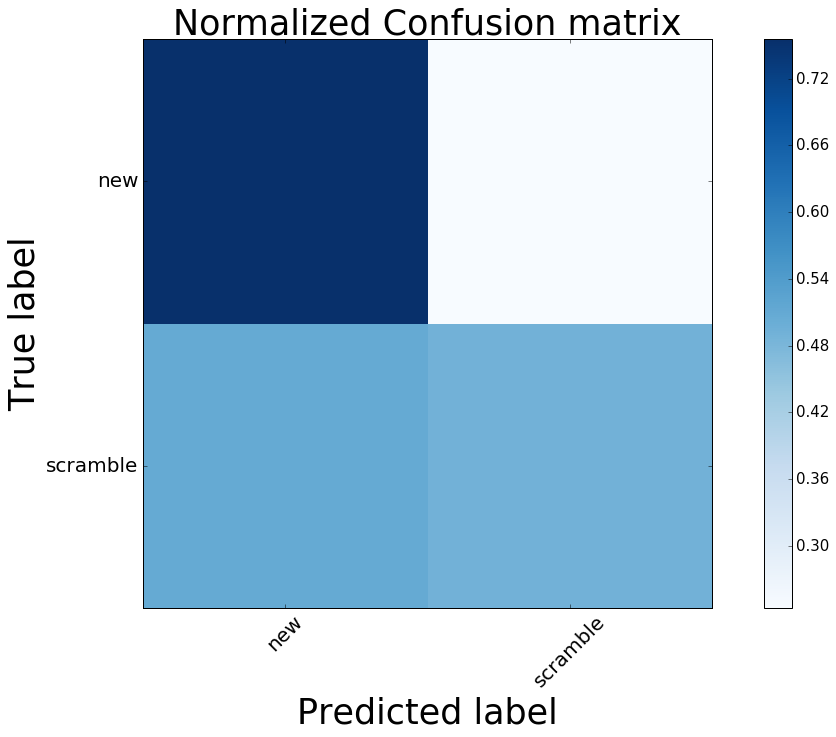

In [77]:
# Plot confusion matrix
plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Normalized Confusion matrix', fontsize = 35)
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, fontsize = 20)
plt.yticks(tick_marks, target_names, fontsize = 20)
tight_layout()
plt.ylabel('True label', fontsize = 35)
plt.xlabel('Predicted label',fontsize = 35)
plt.show()

In [78]:
print(score)

0.664864864865
